In [1]:
import os
import datetime
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import numpy as np
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

### feature engineer part
import techjam_fe

%matplotlib inline

In [2]:
def techjam_score(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    return 100 - 100 * np.mean((y_pred-y_true) ** 2 / (np.minimum(2*y_true, y_pred) + y_true)**2)

In [3]:
# Edit data directory here
DATA_DIR = ".\\techjam"

In [4]:
X, y, test_df = techjam_fe.get_prep_data(DATA_DIR)

C:\Users\phiratath.n\Desktop\tj\techjam_fe.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  label = pd.concat([train,test],axis=0,ignore_index=True)


In [5]:
#### Add categorical feature
categorical_feats = ['gender','ocp_cd','age_gnd','gnd_ocp','age_ocp']
X[categorical_feats] = X[categorical_feats].astype('category')
test_df[categorical_feats] = test_df[categorical_feats].astype('category')

In [6]:
X.reset_index(drop=True,inplace=True)
test_df.reset_index(inplace=True)

# Test Train Split

In [7]:
### Log Transformation
y_log = np.log(y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Model 

In [9]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [10]:
##### Log Transformation 

In [11]:
def techjam_feval(y_pred, dtrain):
    y_true = dtrain.get_label()
    return 'techjam_score', techjam_score(np.exp(y_pred), np.exp(y_true)), True

In [12]:
pred_score_list=[]

In [13]:

model_params = {
    "objective": "mape",
    'boosting_type': 'gbdt',
    'metric': {'mape'},
    'num_leaves': 511,
    'learning_rate': 0.01,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [14]:
gbm = lgb.train(model_params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                feval= techjam_feval,
                verbose_eval=50,
                early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 0.0454491	valid_0's techjam_score: 91.3665
[100]	valid_0's mape: 0.0422578	valid_0's techjam_score: 92.1406
[150]	valid_0's mape: 0.0407483	valid_0's techjam_score: 92.4009
[200]	valid_0's mape: 0.04001	valid_0's techjam_score: 92.4645
[250]	valid_0's mape: 0.0396312	valid_0's techjam_score: 92.4538
Early stopping, best iteration is:
[219]	valid_0's mape: 0.0398344	valid_0's techjam_score: 92.4686


In [15]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [16]:
X_test['pred'] = np.exp(y_pred)

C:\Users\phiratath.n\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
pred_score_list.append(np.exp(y_pred))

In [18]:
techjam_score(X_test['pred'],np.exp(y_test['income']))

92.23411368496367

In [19]:
#### Raw Income

In [20]:
def techjam_feval_no_log(y_pred, dtrain):
    y_true = dtrain.get_label()
    return 'techjam_score', techjam_score((y_pred), (y_true)), True

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, (y_train), test_size=0.2, random_state=42)

In [22]:
lgb_train = lgb.Dataset(X_train, y_train,free_raw_data=False)
lgb_eval = lgb.Dataset(X_val, y_val,free_raw_data=False, reference=lgb_train)

In [23]:
gbm = lgb.train(model_params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                feval= techjam_feval_no_log,
                verbose_eval=50,
                early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 0.403095	valid_0's techjam_score: 88.7412
[100]	valid_0's mape: 0.388182	valid_0's techjam_score: 89.7564
[150]	valid_0's mape: 0.380022	valid_0's techjam_score: 90.3626
[200]	valid_0's mape: 0.375079	valid_0's techjam_score: 90.77
[250]	valid_0's mape: 0.372082	valid_0's techjam_score: 91.0265
[300]	valid_0's mape: 0.370303	valid_0's techjam_score: 91.2138
[350]	valid_0's mape: 0.369347	valid_0's techjam_score: 91.3234
[400]	valid_0's mape: 0.368815	valid_0's techjam_score: 91.4065
[450]	valid_0's mape: 0.368535	valid_0's techjam_score: 91.4577
[500]	valid_0's mape: 0.368326	valid_0's techjam_score: 91.5051
[550]	valid_0's mape: 0.368207	valid_0's techjam_score: 91.5427
[600]	valid_0's mape: 0.368149	valid_0's techjam_score: 91.576
[650]	valid_0's mape: 0.368131	valid_0's techjam_score: 91.6003
[700]	valid_0's mape: 0.368097	valid_0's techjam_score: 91.627
[750]	valid_0's mape: 0.368141	valid_0's techjam

In [24]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)



In [25]:
X_test['pred'] = y_pred

C:\Users\phiratath.n\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [26]:
pred_score_list.append(y_pred)

In [27]:
techjam_score(X_test['pred'],y_test['income'])

91.49487739514275

In [28]:
#### Quantile Transformer

In [29]:
from sklearn.preprocessing import QuantileTransformer

In [30]:
def techjam_feval_quantile(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred = qt.inverse_transform(y_pred.reshape((len(y_pred), 1)))[:,0]
    y_true = qt.inverse_transform(y_true.reshape((len(y_true), 1)))[:,0]
    return 'techjam_score', techjam_score(y_pred, y_true), True

In [31]:
#### Leak in Validate set

In [32]:
qt = QuantileTransformer(n_quantiles=10000, output_distribution='uniform', random_state=42)
#y_q = qt.fit_transform(y_train.values.reshape((len(y_q), 1)))[:,0]
#y_val = qt.transform(y_val.values.reshape((len(y_val), 1)))[:,0]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, (y), test_size=0.2, random_state=42)
y_q = qt.fit_transform(y_train.values.reshape((len(y_train), 1)))[:,0]

X_train, X_val, y_train, y_val = train_test_split(X_train, (y_q), test_size=0.2, random_state=42)

In [34]:
lgb_train = lgb.Dataset(X_train, y_train,free_raw_data=False)
lgb_eval = lgb.Dataset(X_val, y_val,free_raw_data=False, reference=lgb_train)

In [35]:
gbm = lgb.train(model_params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                feval= techjam_feval_quantile,
                verbose_eval=50,
                early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 0.212844	valid_0's techjam_score: 91.1185
[100]	valid_0's mape: 0.195744	valid_0's techjam_score: 91.9179
[150]	valid_0's mape: 0.187604	valid_0's techjam_score: 92.2658
[200]	valid_0's mape: 0.183451	valid_0's techjam_score: 92.4142
[250]	valid_0's mape: 0.181352	valid_0's techjam_score: 92.4658
[300]	valid_0's mape: 0.180217	valid_0's techjam_score: 92.4769
Early stopping, best iteration is:
[286]	valid_0's mape: 0.180478	valid_0's techjam_score: 92.4791


In [36]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred = qt.inverse_transform(y_pred.reshape((len(y_pred), 1)))[:,0]

In [37]:
X_test['pred'] = y_pred

C:\Users\phiratath.n\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
techjam_score(X_test['pred'],y_test['income'])

92.27426540465012

In [39]:
#### No leak in Validate set

In [40]:
qt = QuantileTransformer(n_quantiles=10000, output_distribution='uniform', random_state=42)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, (y), test_size=0.2, random_state=42)
#y_q = qt.fit_transform(y_train.values.reshape((len(y_train), 1)))[:,0]

X_train, X_val, y_train, y_val = train_test_split(X_train, (y_train), test_size=0.2, random_state=42)

In [42]:

y_raw = y_train.copy()

#### Split before use transformer

y_train= qt.fit_transform(y_train.values.reshape((len(y_train), 1)))[:,0]

### Only transform

y_val= qt.transform(y_val.values.reshape((len(y_val), 1)))[:,0]

In [43]:
#### Compare distribution

In [44]:
y_raw.values.reshape((len(y_train), 1))[:,0]

array([ 53000., 185000.,  21000., ...,  48000., 307000., 198000.])

C:\Users\phiratath.n\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


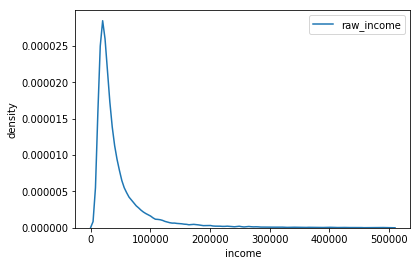

In [45]:


ax = sns.kdeplot(y_raw.values.reshape((len(y_train), 1))[:,0], label='raw_income')
#ax = sns.kdeplot(y_train, label='income')
ax.set(xlabel='income', ylabel='density')
plt.legend()

C:\Users\phiratath.n\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


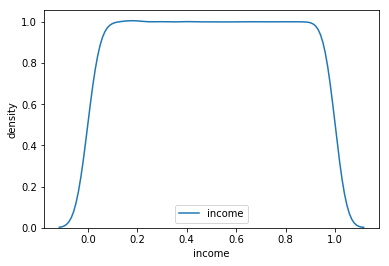

In [46]:
#ax = sns.kdeplot(y_raw, label='raw_income')
ax = sns.kdeplot(y_train, label='income')
ax.set(xlabel='income', ylabel='density')
plt.legend()

In [47]:
lgb_train = lgb.Dataset(X_train,y_train,free_raw_data=False)
lgb_eval = lgb.Dataset(X_val, y_val,free_raw_data=False, reference=lgb_train)

In [48]:
gbm = lgb.train(model_params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                feval= techjam_feval_quantile,
                verbose_eval=50,
                early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 0.212269	valid_0's techjam_score: 91.1147
[100]	valid_0's mape: 0.195202	valid_0's techjam_score: 91.9151
[150]	valid_0's mape: 0.186972	valid_0's techjam_score: 92.276
[200]	valid_0's mape: 0.182923	valid_0's techjam_score: 92.4251
[250]	valid_0's mape: 0.180862	valid_0's techjam_score: 92.471
[300]	valid_0's mape: 0.179738	valid_0's techjam_score: 92.4783
Early stopping, best iteration is:
[291]	valid_0's mape: 0.179886	valid_0's techjam_score: 92.4882


In [49]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred = qt.inverse_transform(y_pred.reshape((len(y_pred), 1)))[:,0]

In [50]:
X_test['pred'] = y_pred

C:\Users\phiratath.n\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [51]:
pred_score_list.append(y_pred)

In [52]:
techjam_score(X_test['pred'],y_test['income'])

92.25796697892422

In [53]:
#### Clip Target

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, (y), test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train.clip(upper=np.percentile(y_train,95),lower=np.percentile(y_train,5)), test_size=0.2, random_state=42)

In [55]:
lgb_train = lgb.Dataset(X_train,y_train,free_raw_data=False)
lgb_eval = lgb.Dataset(X_val, y_val,free_raw_data=False, reference=lgb_train)

In [56]:
gbm = lgb.train(model_params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                feval= techjam_feval_no_log,
                verbose_eval=50,
                early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 0.388839	valid_0's techjam_score: 89.9901
[100]	valid_0's mape: 0.374004	valid_0's techjam_score: 90.9528
[150]	valid_0's mape: 0.365797	valid_0's techjam_score: 91.5199
[200]	valid_0's mape: 0.360518	valid_0's techjam_score: 91.912
[250]	valid_0's mape: 0.35778	valid_0's techjam_score: 92.137
[300]	valid_0's mape: 0.355983	valid_0's techjam_score: 92.298
[350]	valid_0's mape: 0.354993	valid_0's techjam_score: 92.3956
[400]	valid_0's mape: 0.354261	valid_0's techjam_score: 92.4796
[450]	valid_0's mape: 0.353681	valid_0's techjam_score: 92.5435
[500]	valid_0's mape: 0.353355	valid_0's techjam_score: 92.5975
[550]	valid_0's mape: 0.35319	valid_0's techjam_score: 92.6385
Early stopping, best iteration is:
[541]	valid_0's mape: 0.353158	valid_0's techjam_score: 92.6344


In [57]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [58]:
X_test['pred'] = y_pred

C:\Users\phiratath.n\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [59]:
techjam_score(X_test['pred'],y_test['income'])

91.56762967765408

In [60]:
pred_score_list.append(y_pred)

# Predict Distribution 

In [61]:
bin_df  = pd.DataFrame(y_test)
for i in range(5):
    bin_df.loc[(bin_df['income'] > 20000*i)&(bin_df['income'] <= 20000*(i+1)),'bin']=i
    if i==4:
        bin_df.loc[(bin_df['income'] > 100000),'bin']=i

C:\Users\phiratath.n\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


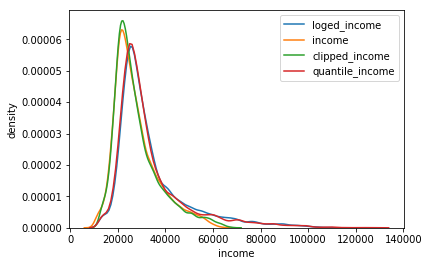

In [62]:
ax = sns.kdeplot(pred_score_list[0], label='loged_income')
ax = sns.kdeplot(pred_score_list[1], label='income')
ax = sns.kdeplot(pred_score_list[-1], label='clipped_income')
ax = sns.kdeplot(pred_score_list[2], label='quantile_income')
ax.set(xlabel='income', ylabel='density')
plt.legend()

In [63]:
bin_df['loged_income']=pred_score_list[0]
bin_df['raw_income']=pred_score_list[1]
bin_df['clipped_income']=pred_score_list[3]
bin_df['quantile_income']=pred_score_list[2]

In [64]:
bin_df.head()

,income,bin,loged_income,raw_income,clipped_income,quantile_income
id,,,,,,
33554,72000.0,3.0,55448.567644,40143.628536,41184.417616,59000.0
9428,53000.0,2.0,25288.602301,17957.481471,18874.882382,27000.0
200,19000.0,0.0,22051.008125,18370.912176,19632.892009,22000.0
12448,22000.0,1.0,25310.924489,19948.987101,19991.518412,26000.0
39490,24000.0,1.0,21939.594956,17826.383686,17827.518859,22000.0


In [65]:
y_test =bin_df['income'].values

In [66]:
score_summary = pd.DataFrame(bin_df.apply(lambda x:techjam_score(x,y_test)),columns=['techjam_score'])

In [67]:
score_summary.iloc[2:,:]

,techjam_score
loged_income,92.234114
raw_income,91.494877
clipped_income,91.567630
quantile_income,92.257967


In [68]:
df_log=pd.DataFrame(bin_df.groupby('bin').apply(lambda x: techjam_score(x['loged_income'],x['income'])))
df_raw=pd.DataFrame(bin_df.groupby('bin').apply(lambda x: techjam_score(x['raw_income'],x['income'])))
df_clip=pd.DataFrame(bin_df.groupby('bin').apply(lambda x: techjam_score(x['clipped_income'],x['income'])))
df_quantile=pd.DataFrame(bin_df.groupby('bin').apply(lambda x: techjam_score(x['quantile_income'],x['income'])))
bin_summary = pd.concat([df_raw,df_clip,df_log,df_quantile],axis=1)

In [69]:
bin_summary.columns = ['raw_income','clipped_income','loged_income','quantile_income']

In [70]:
bin_summary['income bin'] = ['0-20,000','20,000-40,000','40,000-60,000','60,000-80,000','100,000+']

In [74]:
bin_summary

,raw_income,clipped_income,loged_income,quantile_income
income bin,,,,
"0-20,000",95.271712,95.145364,90.282893,90.905053
"20,000-40,000",98.043812,98.078533,98.031724,98.107466
"40,000-60,000",92.272313,92.315466,95.072244,94.757419
"60,000-80,000",86.181076,86.330601,91.073788,90.538563
"100,000+",66.043738,66.613439,75.682353,75.066621


[Text(0,0,'0-20,000'),
 Text(0,0,'20,000-40,000'),
 Text(0,0,'40,000-60,000'),
 Text(0,0,'60,000-80,000'),
 Text(0,0,'100,000+')]

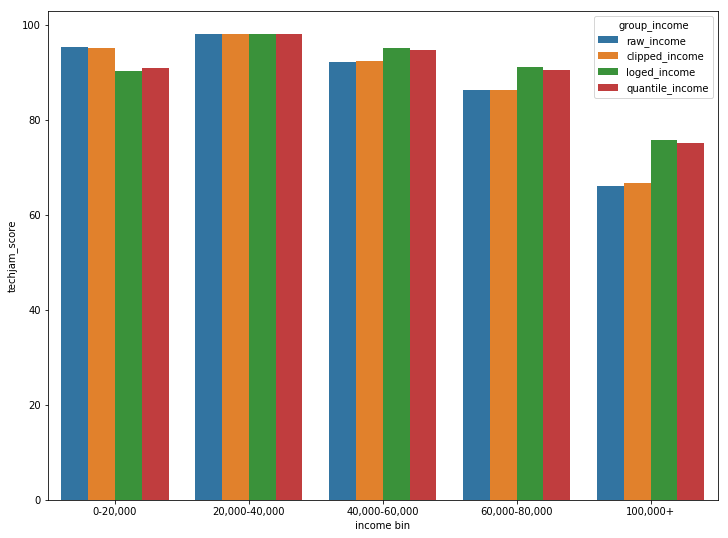

In [72]:
fig_dims = (12, 9)
data = bin_summary.melt('income bin', var_name='group_income', value_name='techjam_score')
fig, ax = plt.subplots(figsize=fig_dims)
ax=sns.barplot(x='income bin', y='techjam_score', hue='group_income', data=data)

ax.set_xticklabels(ax.get_xticklabels())